# UBCF & IBCF - MultiEval Example

This notebook uses the example from the LKPY package as a template. Modifications are made as necessary, but this is largely a copy of the example given with the LKPY package. 

## Setup

We first need to import our libraries.

In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Jacob\\Documents\\GitHub\\lenskit_confidence')

In [21]:
from lenskit.batch import MultiEval
from lenskit.crossfold import partition_users, SampleN
from lenskit.algorithms import basic, als, item_knn, user_knn
from lenskit.datasets import MovieLens
from lenskit import topn, util #, metrics
from lenskit.metrics import predict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Progress bars are useful:

In [3]:
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

C:\Users\Jacob\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


It takes a little while to run things, and can get kinda quiet in here. Let's set up logging so we can see the logging output in the notebook's message stream:

In [4]:
util.log_to_notebook()

[   INFO] lenskit.util.log notebook logging configured


Then set up the data access.

In [25]:
#mlsmall = MovieLens('../data/ml-latest-small')
#mlsmall = MovieLens('../data/ml-1m')
mlsmall = MovieLens('../data/ml-10m')
#mlsmall = MovieLens('../data/ml-20m')

## Experiment

We're going to run our evaluation and store its output in the `my-eval` directory, generating 20-item recommendation lists::

In [26]:
eval = MultiEval('my-eval', predict = True, recommend = 100, eval_n_jobs = 4)

We're going to use a 5-fold cross-validation setup.  We save the data into a list in memory so we have access to the test data later.  In a larger experiment, you might write the partitions to disk and pass the file names to `add_datasets`.

In [27]:
pairs = list(partition_users(mlsmall.ratings, 5, SampleN(5)))
#pairs = (partition_users(mlsmall.ratings, 5, SampleN(5)))

[   INFO] lenskit.crossfold partitioning 10000054 rows for 69878 users into 5 partitions
[   INFO] lenskit.crossfold fold 0: selecting test ratings
[   INFO] lenskit.crossfold fold 0: partitioning training data
[   INFO] lenskit.crossfold fold 1: selecting test ratings
[   INFO] lenskit.crossfold fold 1: partitioning training data
[   INFO] lenskit.crossfold fold 2: selecting test ratings
[   INFO] lenskit.crossfold fold 2: partitioning training data
[   INFO] lenskit.crossfold fold 3: selecting test ratings
[   INFO] lenskit.crossfold fold 3: partitioning training data
[   INFO] lenskit.crossfold fold 4: selecting test ratings
[   INFO] lenskit.crossfold fold 4: partitioning training data


In [28]:
eval.add_datasets(pairs, name = 'ML-Small')

In [29]:
nhbr_range = [10, 25, 50, 75] #, 50] #, 75] #, 200] #, 50, 75, 100]

UBCF

In [30]:
eval.add_algorithms([user_knn.UserUser(nnbrs = f, aggregate = 'weighted-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'UserKNN-Weighted')

eval.add_algorithms([user_knn.UserUser(nnbrs = f, aggregate = 'average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'UserKNN-Average')

IBCF

In [31]:
eval.add_algorithms([item_knn.ItemItem(nnbrs = f, aggregate = 'weighted-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'ItemKNN-Weighted')

eval.add_algorithms([item_knn.ItemItem(nnbrs = f, aggregate = 'average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'ItemKNN-Average')

And finally, we will run the experiment!

In [ ]:
eval.run(progress = tqdm)

[   INFO] lenskit.batch._multi starting run 1: UserUser(nnbrs=10, min_sim=0) on ML-Small:1
[   INFO] lenskit.batch._multi adapting UserUser(nnbrs=10, min_sim=0) into a recommender
[   INFO] lenskit.batch._multi training algorithm UserUser(nnbrs=10, min_sim=0) on 9930174 ratings
[   INFO] lenskit.algorithms.basic trained unrated candidate selector for 9930174 ratings
[   INFO] lenskit.batch._multi trained algorithm UserUser(nnbrs=10, min_sim=0) in 4.55s
[   INFO] lenskit.batch._multi generating 69880 predictions for TopN/UserUser(nnbrs=10, min_sim=0)
[   INFO] lenskit.sharing.shm serialized TopN/UserUser(nnbrs=10, min_sim=0) to 1137 pickle bytes with 13 buffers of 280494520 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch._predict generating 69880 predictions for 13976 users (setup took  289ms)
[   INFO] lenskit.batch._predict generated 69880 predictions for 13976 users in 4m45.57s
[   INFO] lenskit.batch._multi generated predicti

## Analysis

Now that the experiment is run, we can read its outputs.

First the run metadata:

In [13]:
runs = pd.read_csv('my-eval/runs.csv')
runs.set_index('RunId', inplace = True)
runs.head()

,DataSet,Partition,AlgoClass,AlgoStr,name,nnbrs,TrainTime,PredTime,RecTime
RunId,,,,,,,,,
1,ML-Small,1,UserUser,"UserUser(nnbrs=10, min_sim=0)",UserKNN-Weighted,10,5.557253,19.654374,25.528618
2,ML-Small,1,UserUser,"UserUser(nnbrs=25, min_sim=0)",UserKNN-Weighted,25,0.479763,17.352510,27.266305
3,ML-Small,1,UserUser,"UserUser(nnbrs=50, min_sim=0)",UserKNN-Weighted,50,0.456338,17.627729,28.645370
4,ML-Small,1,UserUser,"UserUser(nnbrs=75, min_sim=0)",UserKNN-Weighted,75,0.430928,17.601646,30.146061
5,ML-Small,1,UserUser,"UserUser(nnbrs=10, min_sim=0)",UserKNN-Average,10,0.483857,17.576997,26.088862


This describes each run - a data set, partition, and algorithm combination.  To evaluate, we need to get the actual recommendations, and combine them with this:

In [14]:
recs = pd.read_parquet('my-eval/recommendations.parquet')
#del recs['RunId']
recs.head()

,item,score,user,rank,RunId
0,572,5.046758,5,1,1
1,557,4.966881,5,2,1
2,2309,4.745716,5,3,1
3,1787,4.689896,5,4,1
4,1149,4.594458,5,5,1


In [ ]:
recs

Getting the predictions...

In [15]:
preds = pd.read_parquet('my-eval/predictions.parquet')
preds

,RunId,user,item,rating,prediction
0,1,5,3514,2.0,2.737919
1,1,5,1759,4.0,3.863363
2,1,5,3476,3.0,3.075272
3,1,5,1192,5.0,3.812009
4,1,5,1909,3.0,2.253495
...,...,...,...,...,...
483195,9,6038,1419,4.0,3.550519
483196,9,6038,3548,4.0,3.589343
483197,9,6038,1223,5.0,3.853757
483198,9,6038,1148,5.0,4.230793


We're going to compute per-(run,user) evaluations of the recommendations *before* combining with metadata. 

In order to evaluate the recommendation list, we need to build a combined set of truth data. Since this is a disjoint partition of users over a single data set, we can just concatenate the individual test frames:

In [16]:
truth = pd.concat((p.test for p in pairs), ignore_index = True)
truth

,Unnamed: 0,user,item,rating,timestamp
0,319,5,3514,2.0,978243869
1,272,5,1759,4.0,978245513
2,384,5,3476,3.0,978245916
3,307,5,1192,5.0,978244493
4,293,5,1909,3.0,978246479
...,...,...,...,...,...
30195,998294,6033,1954,4.0,956713865
30196,998303,6033,1210,4.0,956713950
30197,998309,6033,733,3.0,956713999
30198,998301,6033,2947,4.0,956713950


Now we can set up an analysis and compute the results.

In [17]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg) # precision, recall, recip_rank, dcg, ndcg
rla.add_metric(topn.precision)
#rla.add_metric(predict.rmse)
raw_ndcg = rla.compute(recs, truth)
raw_ndcg.head()

[   INFO] lenskit.topn analyzing 9663600 recommendations (30200 truth rows)
[   INFO] lenskit.topn using rec key columns ['RunId', 'user']
[   INFO] lenskit.topn using truth key columns ['user']
[   INFO] lenskit.topn collecting truth data
[   INFO] lenskit.topn collecting metric results
[   INFO] lenskit.sharing.shm serialized <lenskit.topn._RLAJob object at 0x00000166C1465D00> to 2634822 pickle bytes with 24163 buffers of 310080800 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 2 workers
[   INFO] lenskit.topn measured 96636 lists in 2m56.91s


nrecs      ndcg  precision
RunId user                            
1     5     100.0  0.000000       0.00
      6     100.0  0.000000       0.00
      15    100.0  0.268005       0.03
      27    100.0  0.000000       0.00
      28    100.0  0.045068       0.01

Next, we need to combine this with our run data, so that we know what algorithms and configurations we are evaluating:

In [18]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
ndcg = raw_ndcg.join(runs[['name', 'nnbrs']], on = 'RunId')
ndcg.head()

nrecs      ndcg  precision              name  nnbrs
RunId user                                                     
1     5     100.0  0.000000       0.00  UserKNN-Weighted     10
      6     100.0  0.000000       0.00  UserKNN-Weighted     10
      15    100.0  0.268005       0.03  UserKNN-Weighted     10
      27    100.0  0.000000       0.00  UserKNN-Weighted     10
      28    100.0  0.045068       0.01  UserKNN-Weighted     10

We can compute the overall average performance for each algorithm configuration - fillna makes the group-by happy with Popular's lack of a feature count:

In [19]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
ndcg.fillna(0).groupby(['name', 'nnbrs'])['ndcg','precision'].mean()

<ipython-input-19-9f49e897c919>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ndcg.fillna(0).groupby(['name', 'nnbrs'])['ndcg','precision'].mean()


ndcg  precision
name             nnbrs                     
ItemKNN-Average  10     0.041646   0.006123
                 25     0.040809   0.006389
                 50     0.038676   0.006257
                 75     0.037665   0.006210
ItemKNN-Weighted 10     0.041580   0.006156
                 25     0.040937   0.006339
                 50     0.039854   0.006336
                 75     0.038922   0.006270
UserKNN-Average  10     0.033548   0.005200
                 25     0.037122   0.006041
                 50     0.038699   0.006447
                 75     0.039609   0.006652
UserKNN-Weighted 10     0.031351   0.004945
                 25     0.034002   0.005637
                 50     0.034999   0.005913
                 75     0.035670   0.006092

Now, we can plot this:

Text(0, 0.5, 'nDCG')

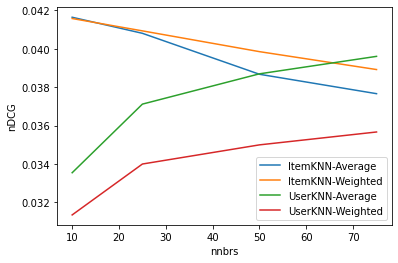

In [23]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
scores = ndcg.groupby(['name', 'nnbrs'])['ndcg'].mean().reset_index()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in scores.groupby('name'):
    plt.plot(data['nnbrs'], data['ndcg'], label=algo)
    
#plt.yticks(np.arange(0.002, 0.011, 0.001))
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('nDCG')

Text(0, 0.5, 'Precision')

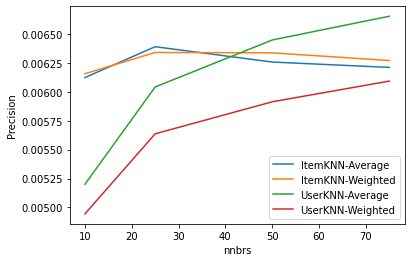

In [24]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
scores = ndcg.groupby(['name', 'nnbrs'])['precision'].mean().reset_index()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in scores.groupby('name'):
    plt.plot(data['nnbrs'], data['precision'], label=algo)
    
#plt.yticks(np.arange(0.0015, 0.006, 0.0005))
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('Precision')

In [ ]:
#truth # user, item, rating, timestamp - 3355
#preds # RunId, user, item rating, prediction

### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
pred_acc = preds.join(runs[['name', 'nnbrs']], on = 'RunId')
pred_acc.head()


#from lenskit.metrics.predict import rmse
#rmse(preds['prediction'], preds['rating'])

In [ ]:
#pred_acc.loc[pred_acc['prediction'] > 5,'prediction'] = 5
#pred_acc.loc[pred_acc['prediction'] < 1,'prediction'] = 1

pred_acc['se'] = (pred_acc['rating'] - pred_acc['prediction'])**2

In [ ]:
np.sqrt(pred_acc.groupby(['name', 'nnbrs'])['se'].mean())

In [ ]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
knn_pred_scores = np.sqrt(pred_acc.groupby(['name', 'nnbrs'])['se'].mean()).reset_index()
knn_pred_scores.head()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in knn_pred_scores.groupby('name'):
    plt.plot(data['nnbrs'], data['se'], label=algo)
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('RMSE')